In [150]:
%matplotlib notebook
from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd

In [92]:
def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                result.append(experiment_results)
            except:
                pass
    return result
def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [95]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [141]:
experiment_logs = './results/mlp_config_with_lambdarank_2020_11_29T22_58_32/stdout'
data = get_data_from_logs(experiment_logs, 8)
df = pd.DataFrame(data).set_index('model_name').sort_values('ndcg@40')
df

,precision@5,ndcg@40,recall@5,SPS@10,apr@10,pairwise_cos_sim@10,model_build_time,model_inference_time,model_metadata
model_name,,,,,,,,,
top_recommender,0.183161,0.375650,0.017414,0.035038,25.972900,0.271636,0.000003,58.344627,{'proxy_model': 'filter_seen_recommender'}
lightfm_30_WARP,0.197998,0.404947,0.014380,0.027887,1467.195066,0.062559,467.563421,117.567283,{'proxy_model': 'filter_seen_recommender'}
lightfm_30_BPR,0.195388,0.405142,0.014093,0.027172,1454.778066,0.062330,464.010699,116.932151,{'proxy_model': 'filter_seen_recommender'}
APREC-GMLPHE-BCE,0.239936,0.459268,0.019105,0.042903,368.516643,0.169612,6554.549745,777.409338,"{'epochs_trained': 109, 'best_val_ndcg': 0.050..."
svd_recommender_30,0.255631,0.460660,0.022456,0.040400,141.434376,0.184090,21.906488,52.890914,{'proxy_model': 'filter_seen_recommender'}
APREC-GMLPHE-XENDCG-linear,0.277011,0.491862,0.025335,0.067394,419.726117,0.177630,8930.495101,768.015303,"{'epochs_trained': 197, 'best_val_ndcg': 0.060..."
APREC-GMLPHE-XENDCG-sigmoid,0.284126,0.500590,0.025943,0.072578,500.799178,0.174934,5004.475312,769.451013,"{'epochs_trained': 65, 'best_val_ndcg': 0.0611..."
APREC-GMLPHE-Lambdarank,0.288774,0.518030,0.027147,0.089024,713.361923,0.148337,24207.497509,770.609188,"{'epochs_trained': 95, 'best_val_ndcg': 0.0770..."


<IPython.core.display.Javascript object>


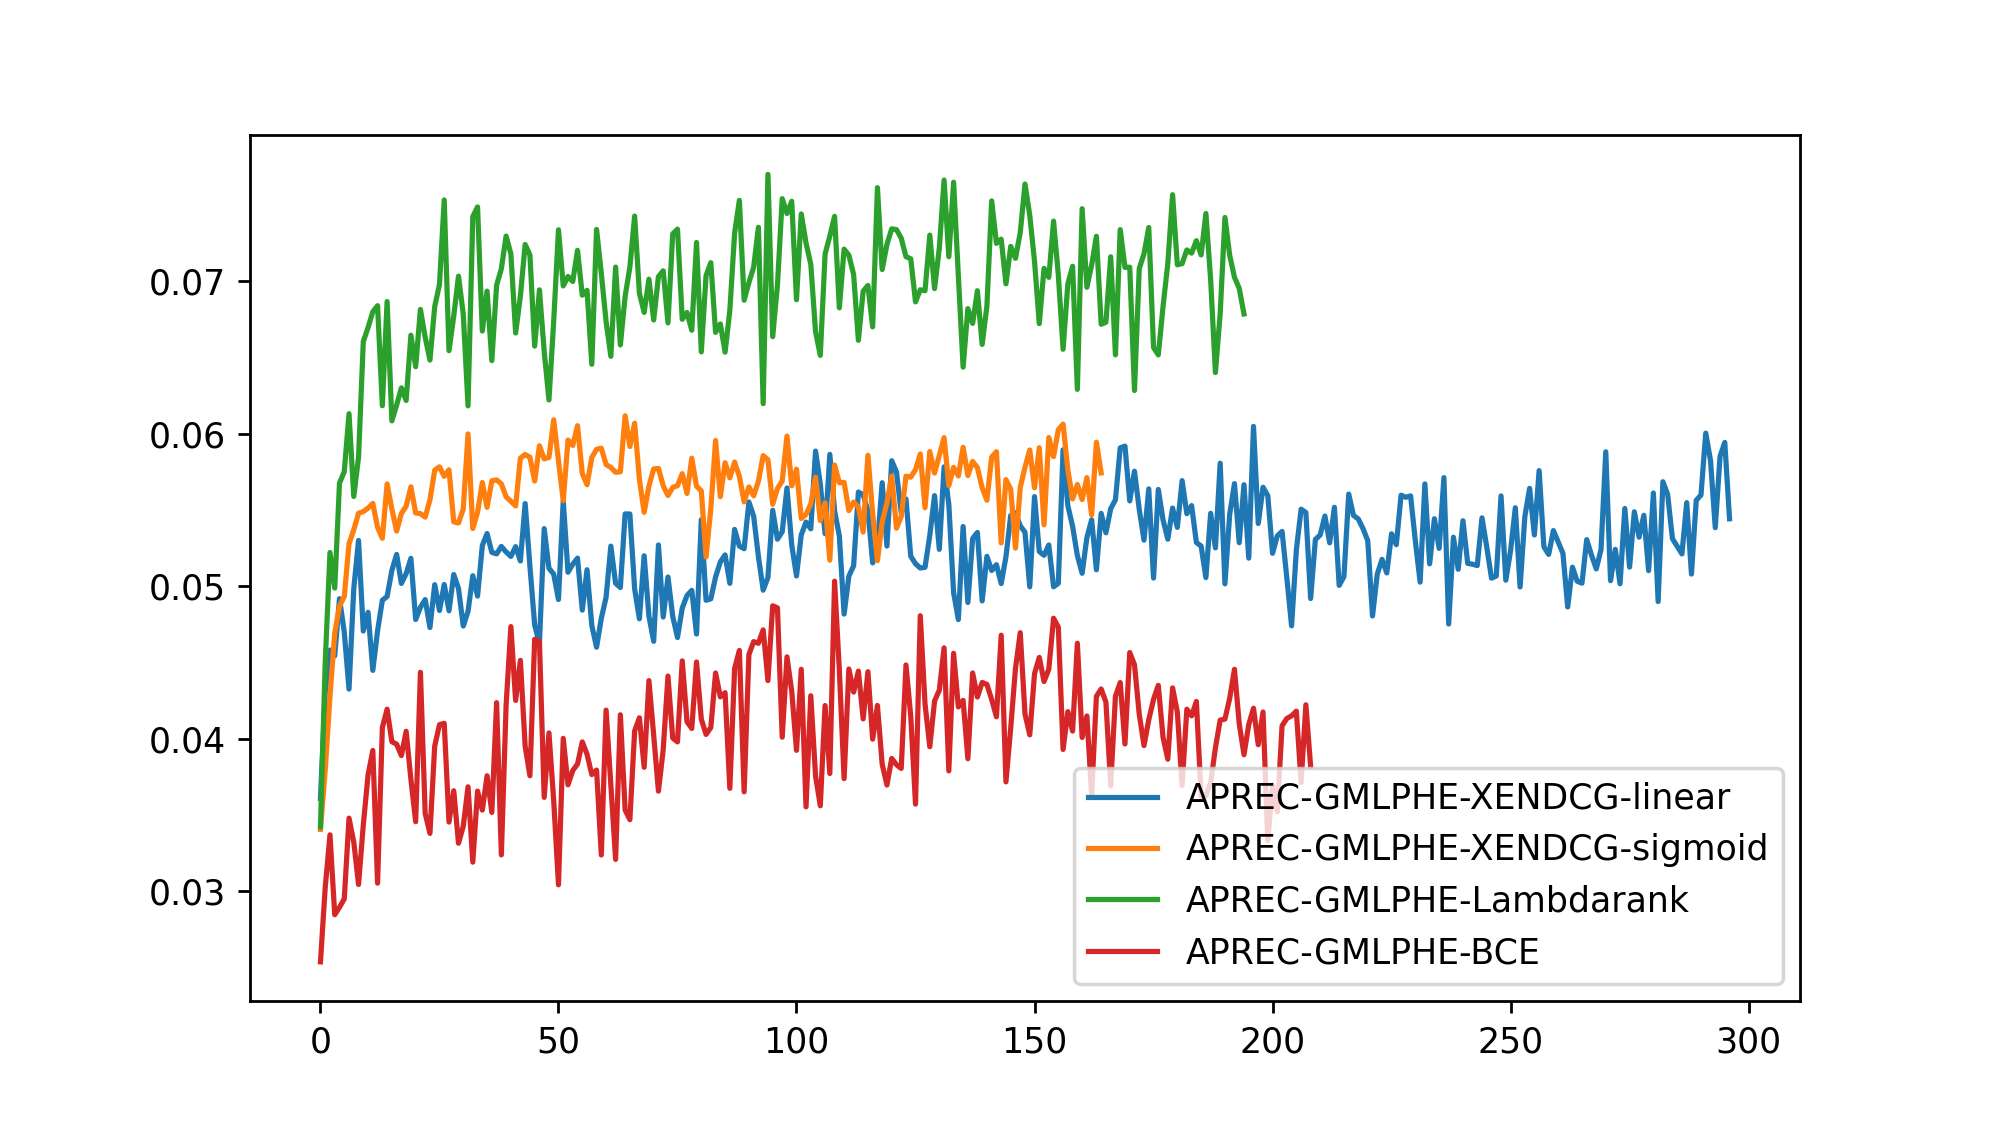

In [180]:
plt.figure(figsize=(8, 4.5))
for recommender in data:
    if 'val_ndcg_history' in recommender['model_metadata']:
        history = moving_average(recommender['model_metadata']['val_ndcg_history'], 1)
        plt.plot(history, label=recommender['model_name'])
    
plt.legend()


<IPython.core.display.Javascript object>


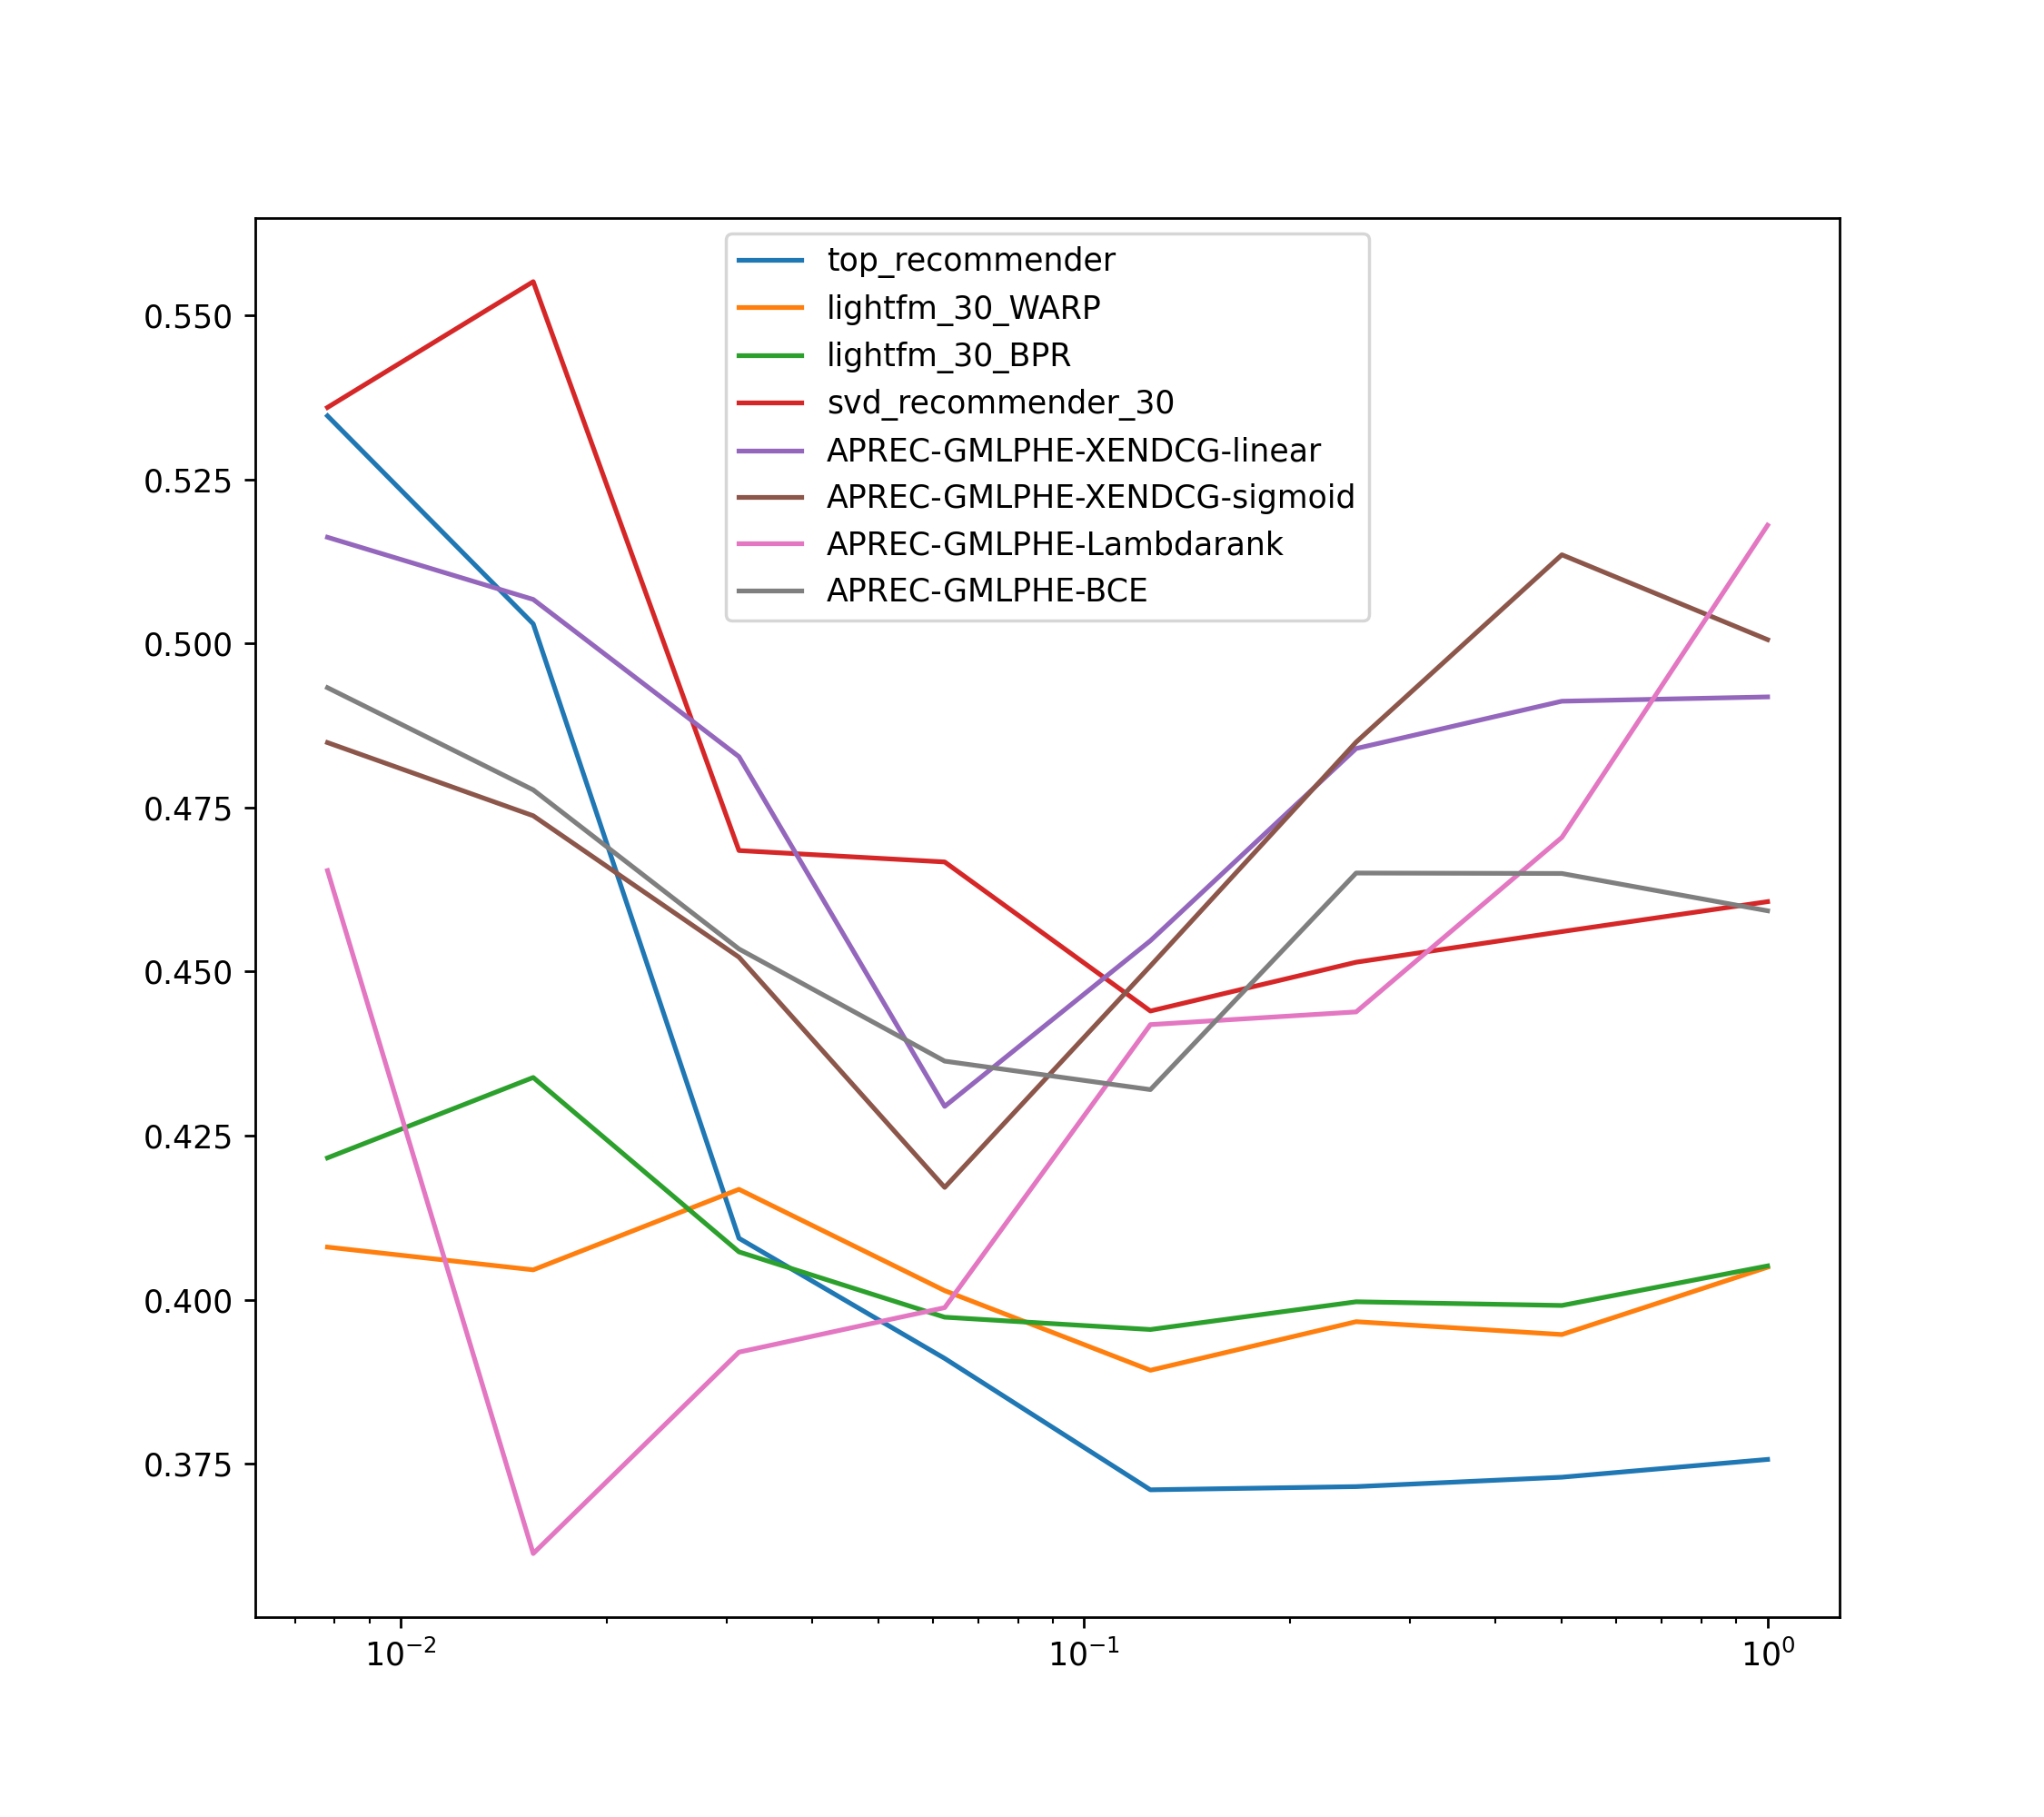

In [177]:
results = defaultdict(list)
n_experiments = 8

fractions = []
for experiment_num in range (1, n_experiments + 1,):
    fraction = (2 ** (experiment_num - n_experiments))
    fractions.append(fraction)
    data = get_data_from_logs(experiment_logs, experiment_num)
    for recommender in data:
        results[recommender['model_name']].append(recommender['ndcg@40'])
        
plt.figure(figsize=(9, 8))
plt.xscale('log')

        
for recommender in results:
    plt.plot(fractions[0:], results[recommender][0:], label=recommender)
    
plt.legend()


In [157]:
results['top_recommender']

[0.3756500509069256,
 0.3756500509069256,
 0.3756500509069256,
 0.3756500509069256,
 0.3756500509069256,
 0.3756500509069256,
 0.3756500509069256,
 0.3756500509069256]

In [2]:
6000 / 138000

0.043478260869565216